In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving drive.py to drive.py
User uploaded file "drive.py" with length 4415 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import INPUT_SHAPE, batch_generator, augument, preprocess

In [ ]:
DATA_DIR = './data/'
KEEP_PROB = 1
EPOCHS = 10
BATCH_SIZE = 32

### load the driving log (csv format) 

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/CarND/CarND-Behavioral-Cloning/data.zip'

In [ ]:
import os
import pandas as pd
import numpy as np

"""
Load training data and split it into training and validation set
"""

data_df = pd.read_csv(os.path.join(DATA_DIR, 'driving_log.csv'))

# Remove the white space 
X = np.array([{item.strip() for item in s} for s in data_df[['center','left','right']].values])  
y = data_df['steering'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

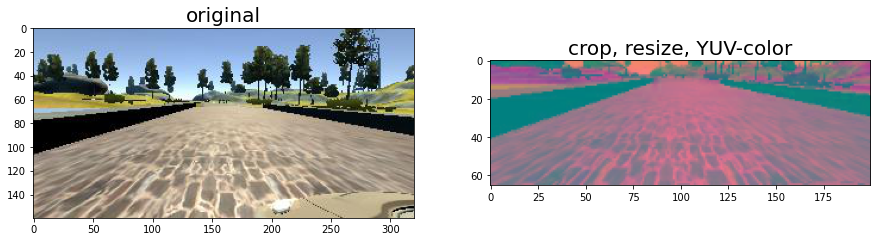

In [ ]:
sample_path = DATA_DIR + '/IMG/left_2016_12_01_13_30_48_287.jpg'

sample_image = plt.imread(sample_path.strip())
process_image = preprocess(sample_image)

fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].imshow(sample_image.squeeze())
axs[0].set_title('original',fontsize=20)

axs[1].imshow(process_image.squeeze())
axs[1].set_title('crop, resize, YUV-color',fontsize=20)

plt.show()

In [ ]:
# create data generator
print(len(X_train))

6428


### Build the modified NVIDIA model 

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(36,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(48,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(64,(3, 3), activation='elu'))
model.add(Conv2D(64,(3, 3), activation='elu'))
#model.add(Dropout(KEEP_PROB))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

### Run training

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only='true',
                             mode='auto')

model.compile(loss='mse', optimizer='adam')
     
history_object = model.fit(batch_generator(DATA_DIR, X_train, y_train, BATCH_SIZE, True), 
                  steps_per_epoch=len(X_train)//BATCH_SIZE,
                  validation_data=batch_generator(DATA_DIR, X_valid, y_valid, BATCH_SIZE, False), 
                  validation_steps=len(X_valid)//BATCH_SIZE,
                  epochs = EPOCHS,
                  callbacks=[checkpoint],
                  verbose=1,
                  shuffle=1)

Epoch 1/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0336 - val_loss: 0.0146
Epoch 2/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0314 - val_loss: 0.0113
Epoch 3/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0308 - val_loss: 0.0107
Epoch 4/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0304 - val_loss: 0.0148
Epoch 5/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0312 - val_loss: 0.0132
Epoch 6/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0299 - val_loss: 0.0110
Epoch 7/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0296 - val_loss: 0.0143
Epoch 8/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0301 - val_loss: 0.0119
Epoch 9/10
200/200 [==============================] - 15s 75ms/step - loss: 0.0294 - val_loss: 0.0147
Epoch 10/10
200/200 [==============================] - 15s 75ms/step - loss: 0.029

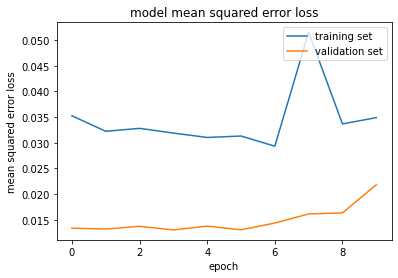

In [ ]:
# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()